# PCAP Clustering
## Data Generation
### Introduction
We used a (3GPP) 5G Lab to generate sample test traffic to run machine learning experiments. The 3rd Generation Partnership Project (3GPP) is a virtual organization that collects the view of seven telecommunications standard development organizations around the world. Since the development of the third generation (3G) mobile network standards, they have been spearheading the standards development effort in this arena. 5G is the technology standard defined by 3GPP from Release 15, fully specified by September 2019. Since mid 2019 numerous 5G networks have been deployed around the world and as of 4Q2023 over 1.1B subscribers are using it.

One of the characteristics of 5G is the distribution of network functionality between control plane (signaling) and user plane (packet forwarding). In addition 5G uses HTTP2 protocol extensively where multiple network functions communicate with each other a common service bus. 5G adopts the recent improvement in system architecture and dictates network functions to be implemented in a containerized format. This allowed the implementation of these network functions as open source containers distributed for experimentation, testing. Some example open-source libraries include [open5gs](https://github.com/open5gs) and [UERANSIM](https://github.com/aligungr/UERANSIM).

### Topology
For testing we used the following lab topology where various network functions as well as User Equipment (UE) were implemented as containers.

<img src="https://raw.githubusercontent.com/b-yond-infinite-network/sharkfest-europe-2023/main/assets/LAAS-Network-Slicing.png"> 



### Test Traffic
Test traffic was generated from a traffic generator, [fortio](fortio)  that allows generation of numerous types of synthetic traffic, including dns, http, tcp, udp and grpc. Fortio was deployed a traffic server and also included in the container image of the UE where fortio client is used to generate test traffic towards the fortio server.

In order to make the test-bed traffic diverse, impairment tool [pumba](https://github.com/alexei-led/pumba) was used. Pumba is used to generate process, network and performance impairments. Process impairments are related to pausing, stopping, killing and removing containers. In this set-up, we didn’t use these capabilities. Instead we relied on the network emulation capabilities of pumba which provides the following network impairments:

* delay

* loss

* duplicate

* corrupt

* rate-limit

In addition to fortio we used icmp_ping from the UE towards the fortio server to create test traffic. All traffic was captured from four Linux bridges to ensure all traffic is captured in a single pcap file corresponding to any control plane and user plane traffic.

```
$ sudo docker network list
NETWORK ID     NAME                   DRIVER    SCOPE
a3bb3f0b4bdc   bridge                 bridge    local
1dbfe33d5a4f   host                   host      local
6a5d4c99167f   laas-5gsa-docker_cp    bridge    local
cc7d4568c741   laas-5gsa-docker_oam   bridge    local
4dec7fb20e13   laas-5gsa-docker_sbi   bridge    local
30dc0e1ba2f9   laas-5gsa-docker_up    bridge    local
b84e483fa615   none                   null      local
tshark -l -i br-6a5d4c99167f -i br-30dc0e1ba2f9 -i br-cc7d4568c741 -i br-4dec7fb20e13 -w <filename.pcap>    
```
Traffic generation was initiated with the following comments (following example is for tcp echo where 100 requests were sent at the rate of 1 req per sec.):
```
ip route add 100.0.0.2 via 10.46.0.2 dev uesimtun0
fortio load -qps -1 -n 100 tcp://100.0.0.2:8078
```

In order to add impurity the following were applied to the user plane function (UPF) container on its eth0 interface connecting it to the fortio server.
```
pumba netem --duration 5m --interface eth0 delay --time 300 --jitter 30 --correlation 50 --distribution normal core_upf
pumba netem --duration 5m --interface eth0 loss --percent 50 --correlation 50 core_upf
pumba netem --duration 5m --interface eth0 rate --rate 10kbit core_upf
pumba netem --duration 5m --interface eth0 duplicate --percent 50 --correlation 50 core_upf
pumba netem --duration 5m --interface eth0 corrupt --percent 50 --correlation 50 core_upf
```

<img src="https://raw.githubusercontent.com/b-yond-infinite-network/sharkfest-europe-2023/main/assets/5g-laas-setup.png" width="70%">



To extract pcap into a csv file:


```
tshark -r [file.pcap]  -T fields -e frame.number -e frame.interface_id -e frame.len -e frame.protocols -e frame.time_delta -e ip.hdr_len -e ip.len -e ip.proto -e ip.ttl -e ip.version -E aggregator="$" -E separator=";" -E header=y > data.csv
```


## Objectives
In the following procedure we will show how to apply an unsupervised approach to cluster pcaps.


### Verify runtime environment

In [1]:
try:
    import google.colab
    IN_COLAB = True
    # Load the autoreload extension for IPython
    %load_ext autoreload
    # Set the autoreload extension to reload modules every time they are imported, so that changes made to code in the src folder are reflected in the running code
    %autoreload 2
    %pip install scikit-learn==1.3.1
except:
    IN_COLAB = False

### Basic installations and imports

In [2]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

### Function to preprocess the data
For each paquet:
* use onehot encoding for protocols
* create an index with filenames
* clean nested data EX: `34$45` -> `34`
* fill missing value with a default value (`-1`)

In [3]:
def encode_protocols(df, colname):
    protocols_df = df[colname].str.get_dummies(sep=':')

    data_with_protocols = pd.concat([df, protocols_df], axis=1)

    return data_with_protocols.drop(colname, axis=1)


def create_index(df):
    df.index = df.apply(lambda x: f"{x['file']}", axis=1)
    df.drop(['file', 'frame.number'], axis=1, inplace=True)
    return df

def clean_nested(df):
    non_numeric_cols = ['ip.hdr_len', 'ip.len', 'ip.proto', 'ip.ttl', 'ip.version']
    for col in non_numeric_cols:
        df[col] = df[col].apply(lambda x: str(x).split('$')[0])
    df[non_numeric_cols] = df[non_numeric_cols].apply(pd.to_numeric, errors='coerce')
    return df

def fill_missing_values(df):
    df.fillna(-1, inplace=True)
    return df

def preprocess(df):
    res = encode_protocols(df, 'frame.protocols')
    res = create_index(res)
    res = clean_nested(res)
    res = fill_missing_values(res)
    return res

### Function to create features
The objective is to create a dataframe where each row is a single file. To do so, we need to aggregate the data per file. We are using `mean` to aggregate the data.

In [4]:
def create_features(df):
    df = df.groupby(level=0).mean()

    return df

### Reading data

In [5]:
%%time
data_path = "https://raw.githubusercontent.com/b-yond-infinite-network/sharkfest-europe-2023-data/main/network-traces-clustering/data.csv"
df = pd.read_csv(data_path,index_col=0)


CPU times: user 80.1 ms, sys: 38.8 ms, total: 119 ms
Wall time: 882 ms


In [6]:
df

,frame.number,frame.interface_id,frame.len,frame.protocols,frame.time_delta,ip.hdr_len,ip.len,ip.proto,ip.ttl,ip.version,file
0,1,3,67,eth:ethertype:ip:udp:data,0.000000,20,53,17,64,4,fortio_dns_corrupt.pcap
1,2,3,59,eth:ethertype:ip:udp:data,0.000091,20,45,17,64,4,fortio_dns_corrupt.pcap
2,3,0,42,eth:ethertype:arp,0.565811,NaN,NaN,NaN,NaN,NaN,fortio_dns_corrupt.pcap
3,4,0,42,eth:ethertype:arp,0.000035,NaN,NaN,NaN,NaN,NaN,fortio_dns_corrupt.pcap
4,5,2,161,eth:ethertype:ip:tcp:data,0.110436,20,147,6,64,4,fortio_dns_corrupt.pcap
...,...,...,...,...,...,...,...,...,...,...,...
738,739,2,161,eth:ethertype:ip:tcp:data,0.416433,20,147,6,64,4,fortio_udpecho_success.pcap
739,740,2,204,eth:ethertype:ip:tcp:data,0.000073,20,190,6,64,4,fortio_udpecho_success.pcap
740,741,2,66,eth:ethertype:ip:tcp,0.000050,20,52,6,64,4,fortio_udpecho_success.pcap
741,742,2,101,eth:ethertype:ip:tcp:data,0.000200,20,87,6,64,4,fortio_udpecho_success.pcap


### Apply preprocessing function

In [7]:
%%time
df = preprocess(df)

CPU times: user 851 ms, sys: 137 ms, total: 989 ms
Wall time: 1.31 s


In [8]:
df

,frame.interface_id,frame.len,frame.time_delta,ip.hdr_len,ip.len,ip.proto,ip.ttl,ip.version,arp,data,...,gtp,http,icmp,ip,pfcp,sctp,smpp,tcp,tls,udp
fortio_dns_corrupt.pcap,3,67,0.000000,20.0,53.0,17.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,0,0,1
fortio_dns_corrupt.pcap,3,59,0.000091,20.0,45.0,17.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,0,0,1
fortio_dns_corrupt.pcap,0,42,0.565811,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
fortio_dns_corrupt.pcap,0,42,0.000035,-1.0,-1.0,-1.0,-1.0,-1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
fortio_dns_corrupt.pcap,2,161,0.110436,20.0,147.0,6.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fortio_udpecho_success.pcap,2,161,0.416433,20.0,147.0,6.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,1,0,0
fortio_udpecho_success.pcap,2,204,0.000073,20.0,190.0,6.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,1,0,0
fortio_udpecho_success.pcap,2,66,0.000050,20.0,52.0,6.0,64.0,4.0,0,0,...,0,0,0,1,0,0,0,1,0,0
fortio_udpecho_success.pcap,2,101,0.000200,20.0,87.0,6.0,64.0,4.0,0,1,...,0,0,0,1,0,0,0,1,0,0


### Create the features

In [9]:
df = create_features(df)

In [10]:
df

,frame.interface_id,frame.len,frame.time_delta,ip.hdr_len,ip.len,ip.proto,ip.ttl,ip.version,arp,data,...,gtp,http,icmp,ip,pfcp,sctp,smpp,tcp,tls,udp
fortio_dns_corrupt.pcap,2.019048,106.961905,0.087618,18.500000,90.738095,14.333333,59.609524,3.642857,0.066667,0.485714,...,0.052381,0.000000,0.000000,0.928571,0.023810,0.038095,0.000000,0.523810,0.057143,0.366667
fortio_dns_delay.pcap,1.987097,113.712903,0.080522,18.170968,97.187097,14.738710,60.241935,3.564516,0.087097,0.461290,...,0.064516,0.000000,0.000000,0.912903,0.038710,0.038710,0.000000,0.467742,0.051613,0.406452
fortio_dns_duplicate.pcap,1.974359,120.841880,0.075371,18.564103,104.858974,14.205128,62.833333,3.658120,0.068376,0.465812,...,0.098291,0.000000,0.000000,0.931624,0.025641,0.025641,0.000000,0.410256,0.042735,0.495726
fortio_dns_loss.pcap,2.000000,114.547085,0.090593,18.869955,98.986547,16.255605,62.089686,3.730942,0.053812,0.484305,...,0.071749,0.000000,0.000000,0.946188,0.058296,0.044843,0.000000,0.448430,0.053812,0.452915
fortio_dns_rate.pcap,2.033898,113.440678,0.097959,18.728814,97.685230,14.772397,61.493947,3.697337,0.060533,0.489104,...,0.048426,0.000000,0.000000,0.939467,0.038741,0.038741,0.000000,0.508475,0.058111,0.392252
fortio_dns_success.pcap,2.042328,114.793651,0.092583,18.611111,98.875661,14.510582,61.261905,3.669312,0.066138,0.500000,...,0.052910,0.000000,0.000000,0.933862,0.031746,0.037037,0.000000,0.505291,0.058201,0.391534
fortio_grpcping_corrupt.pcap,2.033795,131.995823,0.030986,19.529523,117.253085,13.641732,62.408202,3.887982,0.020505,0.602620,...,0.245111,0.000000,0.000000,0.977596,0.013480,0.012151,0.000000,0.640782,0.018986,0.569774
fortio_grpcping_delay.pcap,2.010937,127.395388,0.020577,19.750357,113.050642,13.541607,63.101759,3.940561,0.011888,0.718260,...,0.275083,0.000000,0.000000,0.988112,0.007608,0.008084,0.000000,0.654541,0.011888,0.600571
fortio_grpcping_duplicate.pcap,1.875073,133.846921,0.005255,19.950733,119.778886,12.937537,63.656598,3.988270,0.002346,0.656305,...,0.298534,0.000000,0.000000,0.997654,0.003226,0.001760,0.000587,0.682405,0.002346,0.612023
fortio_grpcping_loss.pcap,2.115418,118.978036,0.075177,19.050388,103.666667,14.125323,61.023686,3.773902,0.045220,0.566753,...,0.123600,0.000000,0.000000,0.954780,0.032730,0.028424,0.000000,0.608096,0.046512,0.441860


### Standardize the data to avoid the scale effect when computing the distance

In [11]:
# Initializing the scaler
scaler = MinMaxScaler()
# Fitting and transforming the data
scaled_data = scaler.fit_transform(df)

In [12]:
scaled_data

array([[0.33496039, 0.02052236, 0.88885435, 0.17989418, 0.0174752 ,
        0.55315624, 0.        , 0.17989418, 0.7654321 , 0.22111018,
        0.        , 0.43206997, 0.        , 0.        , 0.01370947,
        0.        , 0.        , 0.17989418, 0.37998748, 0.84337836,
        0.        , 0.7484038 , 0.9810545 , 0.        ],
       [0.26062582, 0.03455287, 0.81259807, 0.        , 0.03086211,
        0.62879521, 0.14911855, 0.        , 1.        , 0.18091765,
        0.        , 0.61619487, 0.        , 0.        , 0.05577652,
        0.        , 0.        , 0.        , 0.64786905, 0.85763995,
        0.        , 0.65945788, 0.882049  , 0.07849254],
       [0.23099096, 0.04936894, 0.75723509, 0.21494144, 0.04678749,
        0.52923451, 0.76015327, 0.21494144, 0.78505856, 0.18835855,
        0.        , 1.        , 0.        , 0.        , 0.172857  ,
        0.        , 0.        , 0.21494144, 0.41291503, 0.55430698,
        0.        , 0.56826254, 0.72310428, 0.25462481],
       [0.290

### Create a hierarchical clustering

In [13]:
Z = linkage(scaled_data, method='average', metric='cityblock')



### Ploting the results

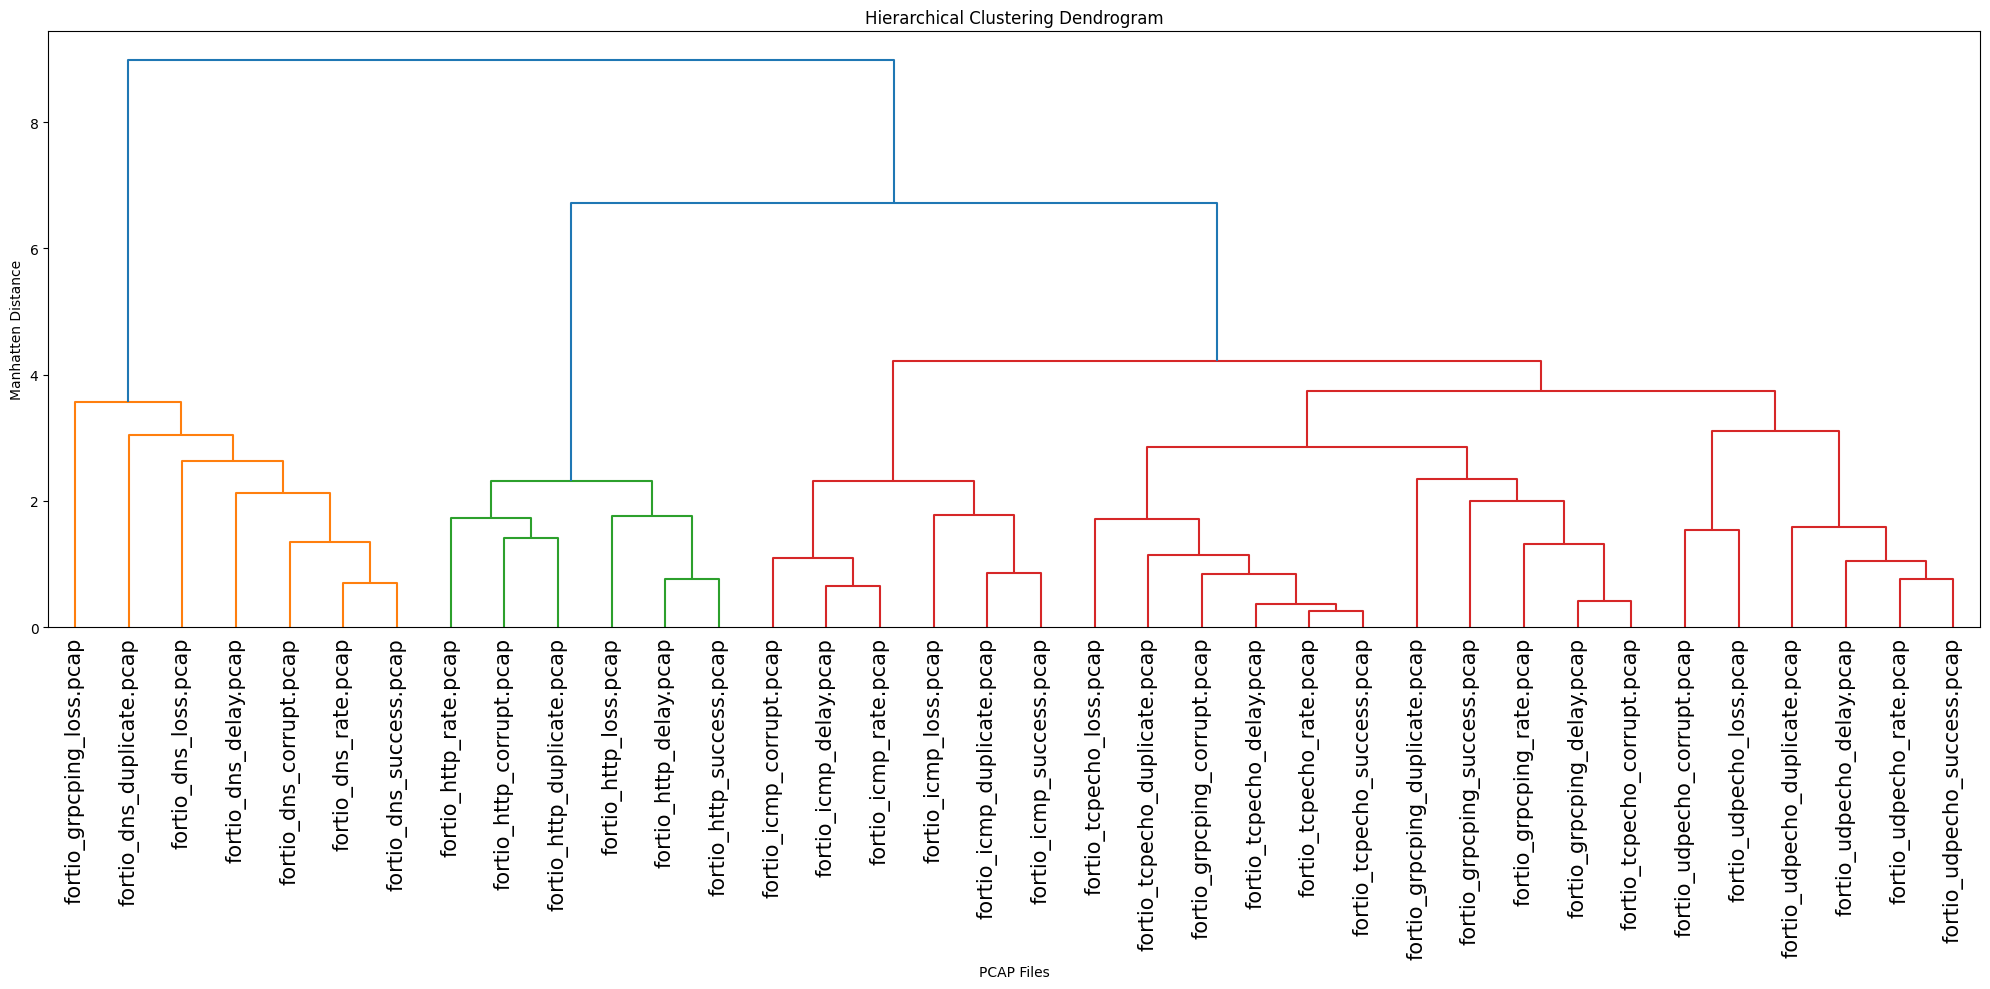

In [14]:
plt.figure(figsize=(20, 10))
dendrogram(Z, labels= df.index.astype(str).tolist(), leaf_rotation=90, leaf_font_size=15)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("PCAP Files")
plt.ylabel("Manhatten Distance")
plt.tight_layout()
plt.show()

### Extract clusters

In [15]:
from scipy.cluster.hierarchy import fcluster
groups = fcluster(Z, t= 6, criterion='maxclust')


In [16]:
groups

array([1, 1, 1, 1, 1, 1, 5, 5, 5, 2, 5, 5, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6], dtype=int32)

In [17]:
df['groups'] = groups

In [18]:
df[df['groups'] == 1].index

Index(['fortio_dns_corrupt.pcap', 'fortio_dns_delay.pcap',
       'fortio_dns_duplicate.pcap', 'fortio_dns_loss.pcap',
       'fortio_dns_rate.pcap', 'fortio_dns_success.pcap'],
      dtype='object')

In [19]:
df[df['groups'] == 2].index

Index(['fortio_grpcping_loss.pcap'], dtype='object')

In [20]:
df[df['groups'] == 3].index

Index(['fortio_http_corrupt.pcap', 'fortio_http_delay.pcap',
       'fortio_http_duplicate.pcap', 'fortio_http_loss.pcap',
       'fortio_http_rate.pcap', 'fortio_http_success.pcap'],
      dtype='object')